# System Identification - ARX

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, with the parameter $\tau$ representing the precision of the process. Measurement noise is also Wiener, with $\gamma$ as precision.

### Forecasting experiment

In this notebook, we will perform a forecasting experiment. The time-series will be split into a training and a validation part. In the training part, we will provide both input and output, and then infer parameters. In the forecasting part, we will only provide input. The parameters will be fixed to their inferred values and we will let the model make predictions for the output. Those predictions are evaluated against the true output.

### Data

Let's first have a look at the data.

In [1]:
using CSV
using DataFrames

In [2]:
using Plots
viz = true;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

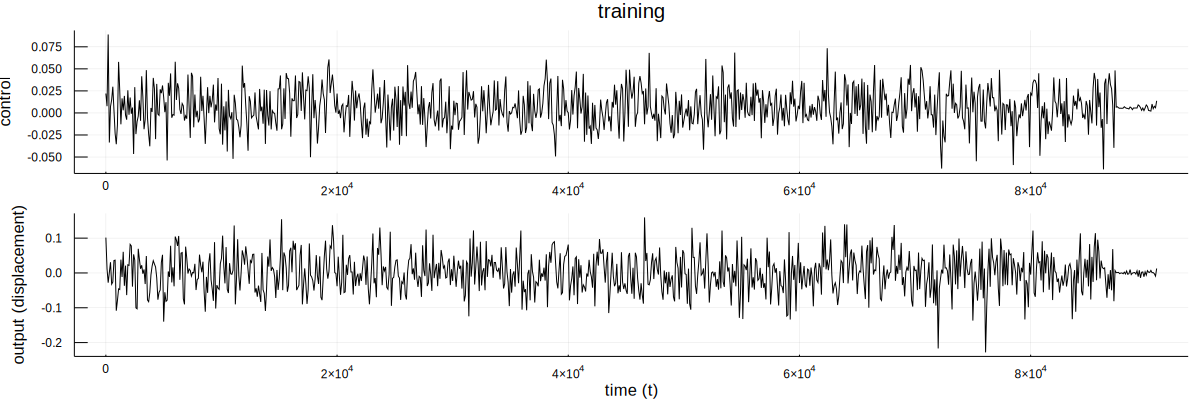

In [5]:
# Plot every n-th time-point to avoid figure size exploding
n = 100

if viz
    p1a = Plots.plot(1:n:T_trn, input_trn[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="training")    
    p1b = Plots.plot(1:n:T_trn, output_trn[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p1 = plot(p1a, p1b, layout=(2,1))
#     Plots.savefig(p1, "viz/training_set.png")
end

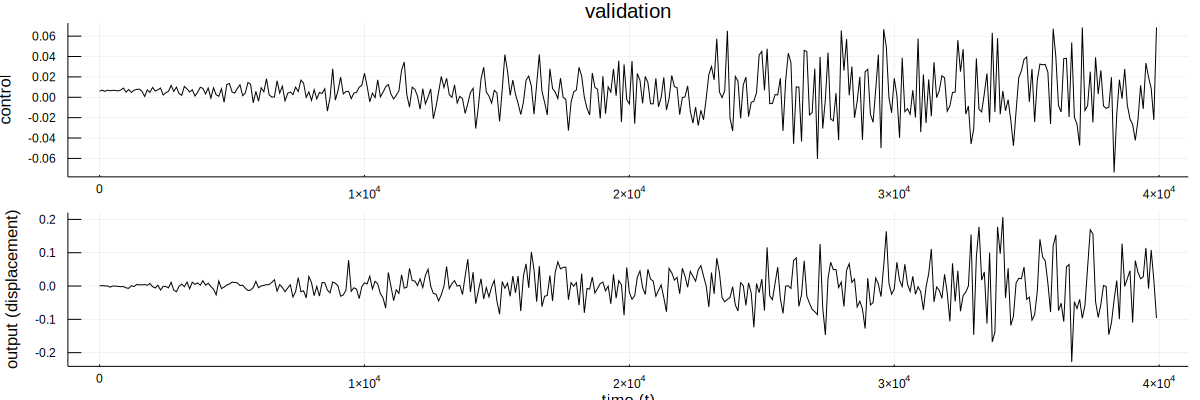

In [6]:
if viz
    p2a = Plots.plot(1:n:T_val, input_val[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="validation")    
    p2b = Plots.plot(1:n:T_val, output_val[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p2 = plot(p2a, p2b, layout=(2,1))
#     Plots.savefig(p2, "viz/validation_set.png")
end

## Solution steps

In this notebook we are tackling the system with a black-box model, ignoring the physical parameters altogether.

### 1. ARX model

NARX stands for Nonlinear AutoRegressive model with eXogenous input. It sports the following output function:

$$\begin{align}
y_t =&\ f(\theta, x_{t-1}, u_t, z_{t-1})  + e_t
\end{align}$$

where $x_{t-1} = [y_{t-1}, \dots, y_{t-M}]^{\top}$ is the vector containing the history of $M$ previous observations and $z_{t-1} = [u_{t-1}, \dots, u_{t-N}]^{\top}$ is the history of $N$ previous inputs. 

In this notebook, $f$ is a linear function:

$$f(\theta, x_{t-1}, u_t, z_{t-1}) = \theta^{\top} [x_{t-1}, u_t, z_{t-1}]$$

So, $\theta$'s dimensionality is $M$+$N$+$1$.

### 2. Convert to Gaussian probability

Integrating out $e_t$ produces a Gaussian node:

$$y_t \sim \mathcal{N}(\theta^{\top} [x_{t-1}, u_t, z_{t-1}], \gamma^{-1}) \, .$$

This is a likelihood node. The state transitions are deterministic and consist of just updating the history vectors $x_t = S_{M}x_{t-1} + s_{M}y_t$ and $z_t = S_{N}z_{t-1} + s_{N}u_t$, where:

$$ S_{M} = \begin{bmatrix} 0 \dots & 0 \\ I_{M-1} & 0 \end{bmatrix} \, , \quad s_{M} = \begin{bmatrix} 1 & 0_1 & \dots & 0_{M-1}\end{bmatrix}^{\top}$$

and likewise for $S_N$.

### 3. Choose priors

We currently have unknown parameters $\theta$ and $\gamma$. The coeffients can be both positive and negative, so we will opt for a Gaussian prior. The prior for a precision parameter $\gamma$ will be a Gamma distribution.

$$\begin{align}
p(\theta) =&\ \text{Normal}(\theta \mid m^{0}_{\theta}, V^{0}_{\theta}) \\
p(\gamma) =&\ \text{Gamma}(\gamma \mid a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

Both priors are conjugate to the Gaussian likelihood node.

### 4. Recognition model

We choose the simplest possible recognition model, a mean-field factorisation of both unknown variables:

$$\begin{align}
q(\theta) =&\ \text{Normal}(\theta \mid m_{\theta}, V_{\theta}) \\
q(\gamma) =&\ \text{Gamma}(\gamma \mid a_\gamma, b_\gamma) 
\end{align}$$

Note that the generative and recognition model match, which means the recognition model's approximation error is potentially $0$.

## Implementation

We implement this model with the toolbox ForneyLab.jl and a custom NARX node. Users can specify $f$, which means the node is an ARX model if $f$ is chosen to be linear.

In [7]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using ProgressMeter

In [8]:
include("../NARX-node/NARX.jl")
using .NARX

In [9]:
# Start graph
graph = FactorGraph()

# Autoregression orders
M = 3
N = 2

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(M+N+1,)), placeholder(:W_θ, dims=(M+N+1,M+N+1)))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

# Setup observation and input vectors
@RV x_t
@RV z_t
@RV u_t

# Nonlinearity
f(θ, x, u, z) = θ'*[x; u; z]

# NARX node with linear f
@RV y_t ~ NAutoregressiveX(θ, x_t, z_t, u_t, γ, g=f, id=:y_t)

# Mark placeholders for observation
placeholder(y_t, :y_t)
placeholder(x_t, :x_t, dims=(M,))
placeholder(z_t, :z_t, dims=(N,))
placeholder(u_t, :u_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14981306537702741896 -->
 
 14981306537702741896 
 
 placeholder_W_θ 
 
<!-- 29629204269111749 -->
 
 29629204269111749 
 
 placeholder_x_t 
 
<!-- 10769250749603195555 -->
 
 10769250749603195555 
 
 NARX 
 y_t 
 
<!-- 29629204269111749--10769250749603195555 -->
 
 29629204269111749--10769250749603195555 
 
 x_t 
 3 x 
 1 out 
 
<!-- 12785910904449332608 -->
 
 12785910904449332608 
 
 placeholder_z_t 
 
<!-- 12785910904449332608--10769250749603195555 -->
 
 12785910904449332608--10769250749603195555 
 
 z_t 
 4 z 
 1 out 
 
<!-- 15607182284365208742 -->
 
 15607182284365208742 
 
 placeholder_a_γ 
 
<!-- 1150539219665479812 -->
 
 1150539219665479812 
 
 Gam 
 gamma_1 
 
<!-- 10769250749603195555--1150539219665479812 -->
 
 10769250749603195555--1150539219665479812 
 
 γ 
 1 out 
 6 τ 
 
<!-- 9777866640966644219 -->
 
 9777866640966644219 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 10769250749603195555--9777866640966644219 -->
 
 10769250749603195555--9777866640966644219 
 
 θ 
 1 out 
 2 θ 
 
<!-- 2029587027308848779 -->
 
 2029587027308848779 
 
 placeholder_b_γ 
 
<!-- 1150539219665479812--15607182284365208742 -->
 
 1150539219665479812--15607182284365208742 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 1150539219665479812--2029587027308848779 -->
 
 1150539219665479812--2029587027308848779 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 6806006222236832509 -->
 
 6806006222236832509 
 
 placeholder_y_t 
 
<!-- 6806006222236832509--10769250749603195555 -->
 
 6806006222236832509--10769250749603195555 
 
 y_t 
 1 y 
 1 out 
 
<!-- 9777866640966644219--14981306537702741896 -->
 
 9777866640966644219--14981306537702741896 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 13586998118720525511 -->
 
 13586998118720525511 
 
 placeholder_m_θ 
 
<!-- 9777866640966644219--13586998118720525511 -->
 
 9777866640966644219--13586998118720525511 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 7627030465820423211 -->
 
 7627030465820423211 
 
 placeholder_u_t 
 
<!-- 7627030465820423211--10769250749603195555 -->
 
 7627030465820423211--10769250749603195555 
 
 u_t 
 5 u 
 1 out

In [10]:
# Define variational message passing procedure
q = PosteriorFactorization(θ, γ, ids=[:θ, :γ])
algo = messagePassingAlgorithm([θ, γ], q, free_energy=false)

# Compile and import compiled functions
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code))
println(source_code)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleVariationalNARXIn5PPPPPN(f, ProbabilityDistribution(Univariate, PointMass, m=data[:y_t]), marginals[:θ], ProbabilityDistribution(Multivariate, PointMass, m=data[:x_t]), ProbabilityDistribution(Multivariate, PointMass, m=data[:z_t]), ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:m_θ]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:W_θ]))
messages[2] = ruleVariationalNARXIn1PNP

### Infer parameters

In [11]:
# Inference parameters
num_iterations = 5

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_θ = (ones(M+N+1,T_trn+1), repeat(.1 .*float(eye(M+N+1)), outer=(1,1,T_trn+1)))
params_γ = (1. *ones(1,T_trn+1), 1. *ones(1,T_trn+1))

# Start progress bar
p = Progress(T_trn, 1, "At time ")

# Filtering
for t = max(M,N)+1:T_trn
    update!(p, t)

    # Initialize marginals
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    
    # Update input, output vectors
    x_t = output[t-1:-1:t-M]
    z_t = input[t-1:-1:t-N]

    # Update observed data
    data = Dict(:y_t => output[t],
                :x_t => x_t,
                :u_t => input[t],
                :z_t => z_t,
                :m_θ => params_θ[1][:,t],
                :W_θ => params_θ[2][:,:,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t])

    for i = 1:num_iterations
            
        # Update precision
        stepγ!(data, marginals)

        # Update coefficients
        stepθ!(data, marginals)
    
    end

    # Store current parameterizations of marginals
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]

end

At time 100%|███████████████████████████████████████████| Time: 0:00:468:53


### Forecast on validation data

In [12]:
# Start graph
graph2 = FactorGraph()

# Clamped variables
@RV x_t
@RV z_t
@RV u_t
@RV θ
@RV γ

# Autoregressive node
@RV y_t ~ NAutoregressiveX(θ, x_t, z_t, u_t, γ, g=f, id=:y_t)

# Indicate observed variables
placeholder(θ, :θ, dims=(M+N+1,))
placeholder(x_t, :x_t, dims=(M,))
placeholder(z_t, :z_t, dims=(N,))
placeholder(u_t, :u_t)
placeholder(γ, :γ)

# Draw time-slice subgraph
ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(y_t, ids=[:y])
algo2 = messagePassingAlgorithm(y_t, q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3305827757336170400 -->
 
 3305827757336170400 
 
 NARX 
 y_t 
 
<!-- 5287565643030612981 -->
 
 5287565643030612981 
 
 placeholder_u_t 
 
<!-- 5287565643030612981--3305827757336170400 -->
 
 5287565643030612981--3305827757336170400 
 
 u_t 
 5 u 
 1 out 
 
<!-- 2736893744964486230 -->
 
 2736893744964486230 
 
 placeholder_θ 
 
<!-- 2736893744964486230--3305827757336170400 -->
 
 2736893744964486230--3305827757336170400 
 
 θ 
 2 θ 
 1 out 
 
<!-- 9193416748589573982 -->
 
 9193416748589573982 
 
 placeholder_γ 
 
<!-- 9193416748589573982--3305827757336170400 -->
 
 9193416748589573982--3305827757336170400 
 
 γ 
 6 τ 
 1 out 
 
<!-- 14060971254054600330 -->
 
 14060971254054600330 
 
 placeholder_x_t 
 
<!-- 14060971254054600330--3305827757336170400 -->
 
 14060971254054600330--3305827757336170400 
 
 x_t 
 3 x 
 1 out 
 
<!-- 18211049548243485410 -->
 
 18211049548243485410 
 
 placeholder_z_t 
 
<!-- 18211049548243485410--3305827757336170400 -->
 
 18211049548243485410--3305827757336170400 
 
 z_t 
 4 z 
 1 out 
 
<!-- 40296605206788461122 -->
 
 40296605206788461122 
 
<!-- 40296605206788461122--3305827757336170400 -->
 
 40296605206788461122--3305827757336170400 
 
 y_t 
 1 y

In [13]:
# Fix estimates of coefficients and precision
mθ = params_θ[1][:,end]
mγ = params_γ[1][1,end]/params_γ[2][1,end]

# Initialize arrays of parameterizations
params_y = (zeros(1,T_val), zeros(1,T_val))

# Start progress bar
p = Progress(T_val, 1, "At time ")

# Perform inference at each time-step
for t = max(M,N)+1:T_val

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:y_t] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_y[1][:,t-1], w=params_y[2][1,t-1])
    
    # Update input, output vectors
    x_t = params_y[1][1,t-1:-1:t-M]
    z_t = input_val[t-1:-1:t-N]
    
    # Set clamped variables
    data = Dict(:u_t => input_val[t],
                :x_t => x_t,
                :z_t => z_t,
                :θ => mθ,
                :γ => mγ)

    # Iterate variational parameter updates
    for i = 1:num_iterations
        
        # Update output prediction
        stepy!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_y[1][1,t] = unsafeMean(marginals[:y_t])
    params_y[2][1,t] = marginals[:y_t].params[:w]

end

At time 100%|███████████████████████████████████████████| Time: 0:00:03


### Visualize forecasted states

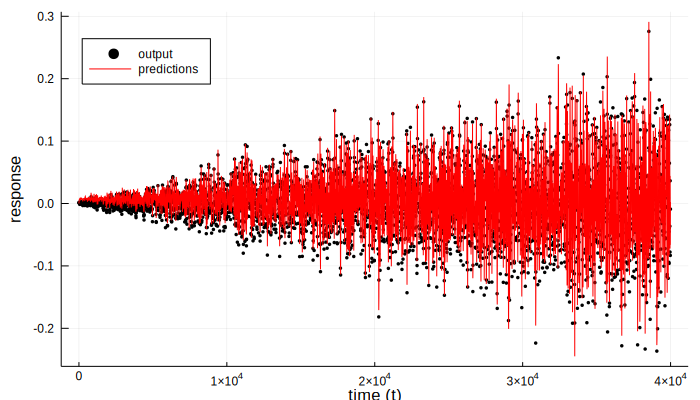

In [14]:
# Extract mean of state marginals
predictions = params_y[1][1,:]

# Plot every n-th time-point to avoid figure size exploding
n = 10

p3 = Plots.scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(1:n:T_val, predictions[1:n:T_val], color="red", linewidth=1, label="predictions", size=(700,400))

In [15]:
Plots.savefig(p3, "viz/forecasts.png")

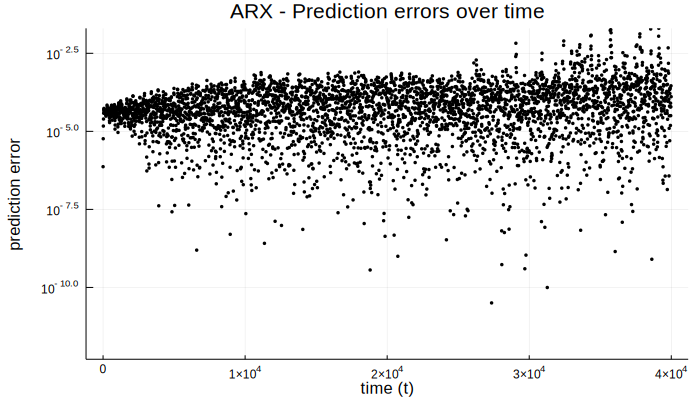

In [16]:
# Error plot
pred_error = (predictions .- output_val).^2
p4 = Plots.scatter(1:n:T_val, 
                   pred_error[1:n:end], 
                   color="black", 
                   label="", 
                   markersize=2, 
                   size=(700,400), 
                   xlabel="time (t)", 
                   ylabel="prediction error",
                   yscale=:log10,
                   ylims=[1e-12, 1e-2],
                   title="ARX - Prediction errors over time")

In [17]:
Plots.savefig(p4, "viz/ARX_pred-errors.png")

In [18]:
println("MSE = "*string(mean(pred_error)))

MSE = 0.00023606850664936624


## Visualize parameter estimates

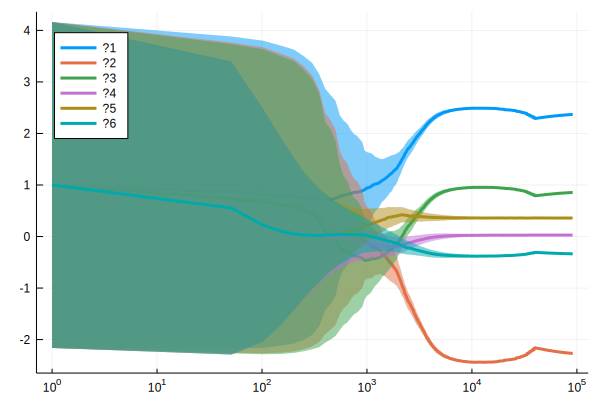

In [19]:
# Extract parameters of final coefficient posteriors
mθ = zeros(T_trn,M+N+1)
sθ = zeros(T_trn,M+N+1)
for k = 1:M+N+1
    mθ[:,k] = params_θ[1][k,2:end]
    sθ[:,k] = sqrt.(inv.(params_θ[2][k,k,2:end]))
end

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 50
    
    # Plot evolution of coefficients
    p7 = Plots.plot(1:n:T_trn, mθ[1:n:T_trn,:], ribbon=[sθ[1:n:T_trn,:], sθ[1:n:T_trn,:]], linewidth=3, labels=["θ1" "θ2" "θ3" "θ4" "θ5" "θ6"], legend=:topleft, xscale=:log10)
end

In [20]:
Plots.savefig(p7, "viz/coefficient_estimates.png")

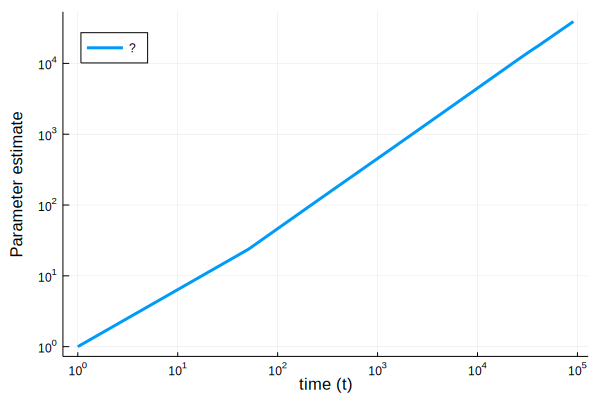

In [21]:
# Extract parameters of final precision posteriors
mγ = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
sγ = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

if viz
    # Plot evolution of precision parameter
#     p8 = Plots.plot(1:n:T_trn, mγ[1:n:T_trn], ribbon=[sγ[1:n:T_trn], sγ[1:n:T_trn]], label="γ", xlabel="time (t)", ylabel="Parameter estimate", linewidth=3, size=(600,400), xscale=:log10, legend=:topleft)
    p8 = Plots.plot(1:n:T_trn, mγ[1:n:T_trn], label="γ", xlabel="time (t)", ylabel="Parameter estimate", linewidth=3, size=(600,400), yscale=:log10, xscale=:log10, legend=:topleft)
end

In [22]:
Plots.savefig(p8, "viz/precision_estimates.png")